# Stress Prediction for Nurses
## AAI 530 Group 5 Github Repository
### Deepti Pamula, Prema Mallikarjunan, Tommy Poole

This project uses machine learning and deep learning techniques to analyze the data found at https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors?resource=download gathered from nurses during the COVID-19 pandemic in a hospital settings, capturing real-world stress factors in a healthcare environment.

In [101]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
import tensorflow as tf

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, precision_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from tqdm.keras import TqdmCallback

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input, BatchNormalization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Ensure memory is clear
tf.keras.backend.clear_session()

In [3]:
# Set seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

In [4]:
# Connect data from colab
# Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Access csv data file from mounted google drive
csv_path = '/content/drive/MyDrive/AAI-530-IoT-Group5/Colab/merged_data.csv'

# Create a dataframe of the csv data
df2 = pd.read_csv(csv_path)

<ipython-input-5-d076502aae57>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path)


In [6]:
"""
# Use for local machine data import
# Import the data
df2 = pd.read_csv("merged_data.csv", low_memory=False, parse_dates=['datetime'])

SyntaxError: incomplete input (<ipython-input-6-52788f9d47bf>, line 1)

In [6]:
# Convert mixed datatype columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

# Exploratory Data Analysis

In [6]:
df2.describe()

,X,Y,Z,EDA,HR,TEMP,label
count,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07
mean,-2.823775e+01,-9.091032e-01,2.382449e+01,3.502127e+00,8.576090e+01,3.223435e+01,1.554202e+00
std,3.142310e+01,3.343382e+01,2.985317e+01,5.656541e+00,1.419642e+01,2.260516e+00,7.891827e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,5.100000e+01,2.409000e+01,0.000000e+00
25%,-5.200000e+01,-1.900000e+01,4.000000e+00,2.242060e-01,7.672000e+01,3.019000e+01,1.000000e+00
50%,-3.300000e+01,1.000000e+00,2.500000e+01,1.157407e+00,8.390000e+01,3.257000e+01,2.000000e+00
75%,-1.400000e+01,1.700000e+01,4.900000e+01,4.077436e+00,9.310000e+01,3.425000e+01,2.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,5.976071e+01,1.802300e+02,3.659000e+01,2.000000e+00


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   EDA       float64
 4   HR        float64
 5   TEMP      float64
 6   id        object 
 7   datetime  object 
 8   label     int32  
dtypes: float64(6), int32(1), object(2)
memory usage: 746.4+ MB


In [8]:
# Review the beginning of the dataframe
df2.head(5)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2


In [ ]:
# Review the end of the dataframe
df2.tail(5)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
11509041,-32.0,-43.0,56.0,3.398877,88.37,33.77,F5,2020-07-23 17:28:59.718749952,2
11509042,-16.0,-52.0,52.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.750000128,2
11509043,-47.0,-78.0,5.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.781250048,2
11509044,-45.0,-77.0,-24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.812499968,2
11509045,-51.0,-77.0,23.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.843749888,2
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2
11509050,-22.0,-24.0,29.0,3.374543,88.33,33.75,F5,2020-07-23 17:29:00.000000000,2


In [ ]:
# Check for missing data
df2.isna().sum()

,0
X,0
Y,0
Z,0
EDA,0
HR,0
TEMP,0
id,0
datetime,0
label,0


In [9]:
# Check for any duplicated data in biometric readings
df2.duplicated().sum()

105606

Generating Histograms: 100%|██████████| 7/7 [07:44<00:00, 66.41s/it]


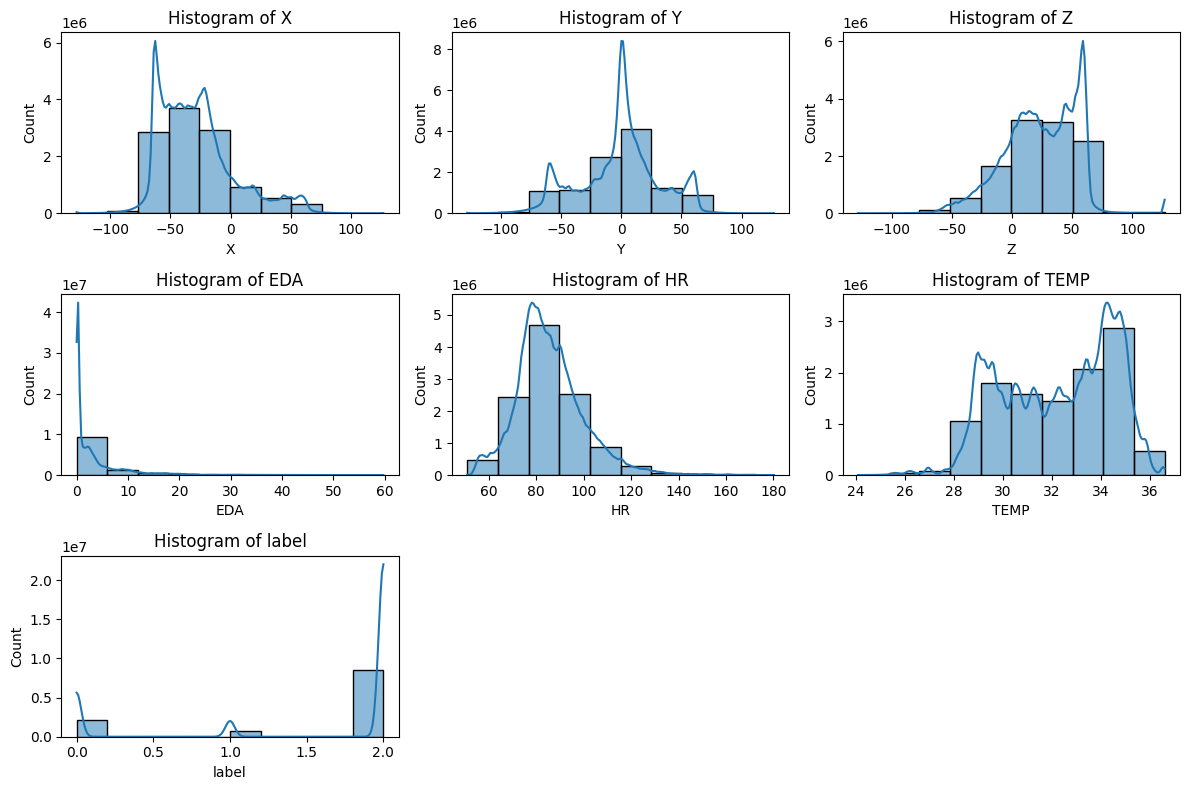

In [ ]:
# Visualize the data as histograms
plt.figure(figsize=(12, 8))
columns = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'label']

# Use tqdm to wrap the loop for progress tracking
for i, col in enumerate(tqdm(columns, desc="Generating Histograms"), 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[col], kde=True, bins=10)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [87]:
# Ensure datetime is in datetime format
df2['datetime'] = pd.to_datetime(df2['datetime'])

In [ ]:
# Set datetime as the index
df2.set_index('datetime', inplace=True)

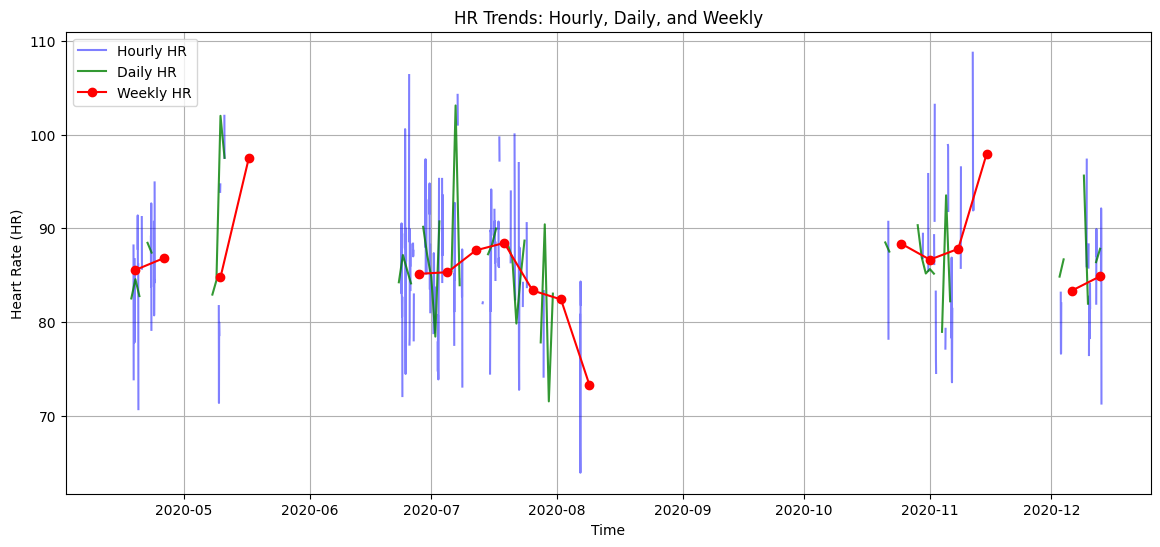

In [ ]:
# Add hourly, daily, weekly attributes to capture trends for heartrate
hr_hourly = df2['HR'].resample('h').mean()
hr_daily = df2['HR'].resample('D').mean()
hr_weekly = df2['HR'].resample('W').mean()
data_hourly = df2[['X', 'Y', 'Z', 'EDA', 'HR']].resample('h').mean()

# Visualize the data to look for trends
plt.figure(figsize=(14, 6))

# Plot all hourly, daily and weekly trends
plt.plot(hr_hourly, linestyle='-', alpha=0.5, color='blue', label='Hourly HR')
plt.plot(hr_daily, linestyle='-', alpha=0.8, color='green', label='Daily HR')
plt.plot(hr_weekly, linestyle='-', alpha=1.0, color='red', marker='o', label='Weekly HR')
plt.xlabel("Time")
plt.ylabel("Heart Rate (HR)")
plt.title("HR Trends: Hourly, Daily, and Weekly")
plt.legend()
plt.grid(True)

plt.show()

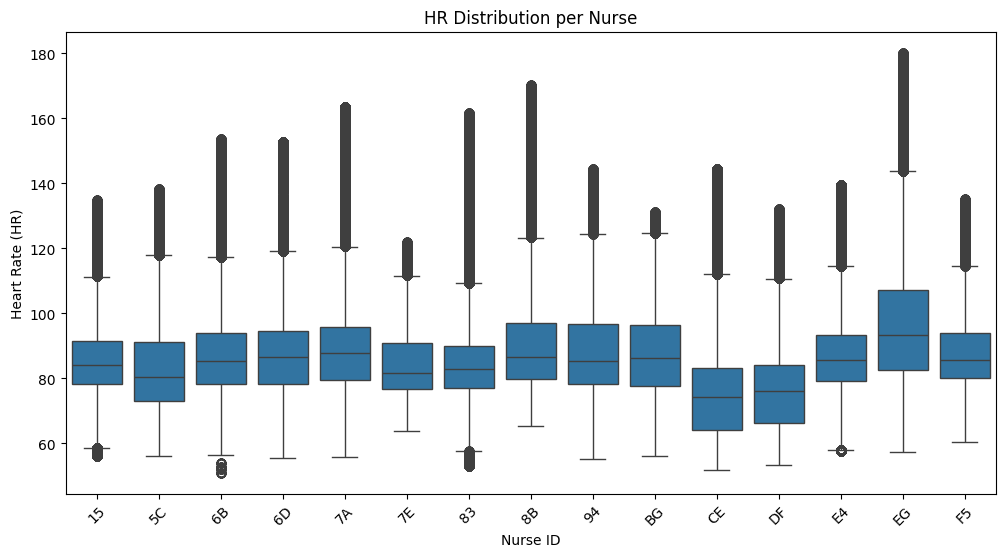

In [ ]:
# Check heartrate for trends in boxplot format
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='HR', data=df2)
plt.title('HR Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Heart Rate (HR)')
plt.xticks(rotation=45)
plt.show()

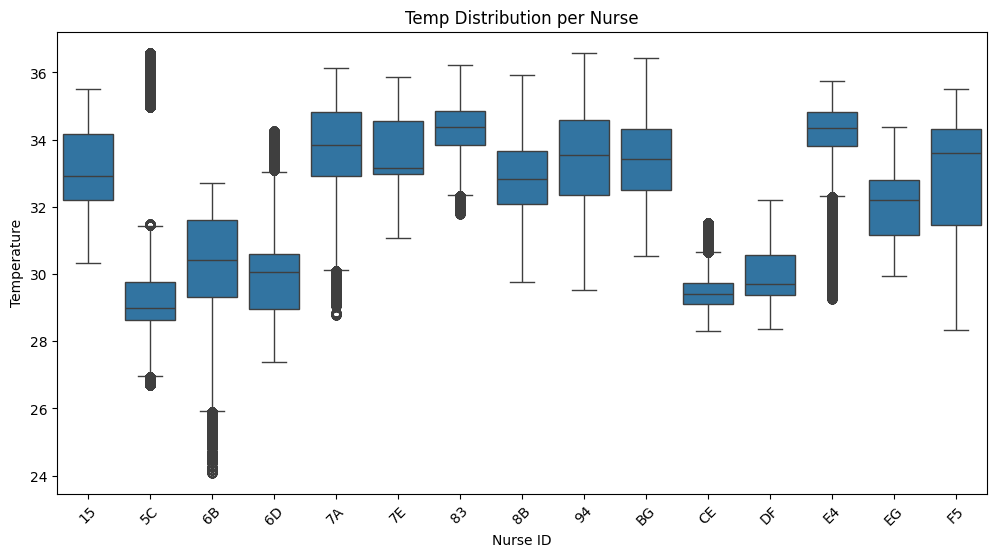

In [ ]:
# Check the temperature field in boxplot format to check for trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='TEMP', data=df2)
plt.title('Temp Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

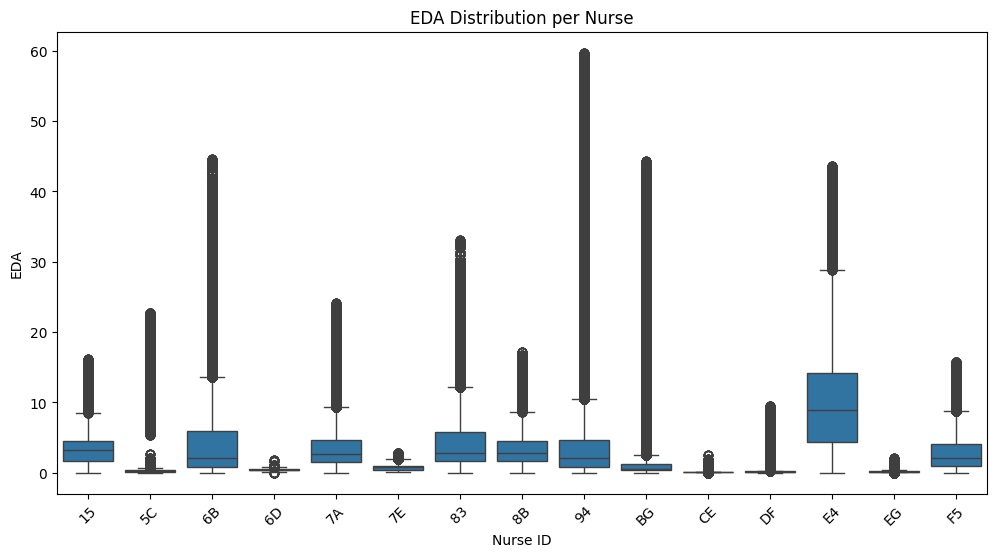

In [ ]:
# Plot the EDA in boxplot to explore trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='EDA', data=df2)
plt.title('EDA Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('EDA')
plt.xticks(rotation=45)
plt.show()

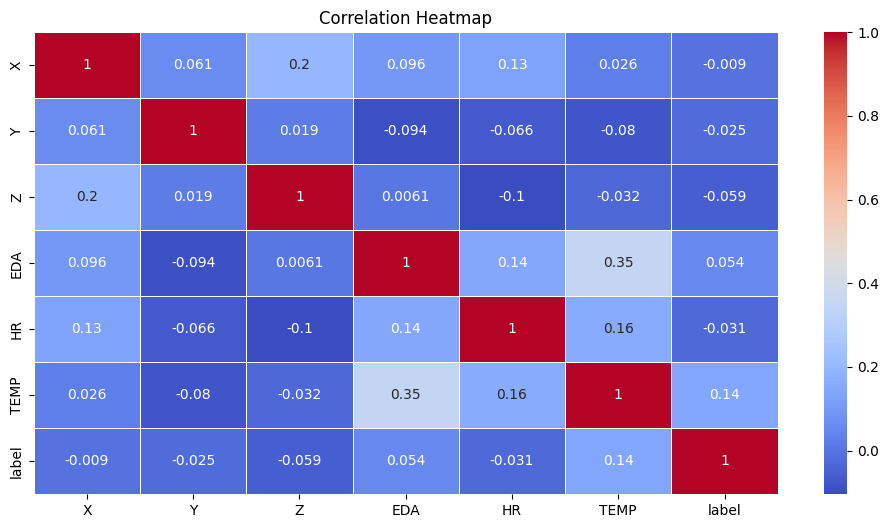

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

#Data Preprocessing

In [7]:
# Label Encoding for 'id' to ensure correct data type
le = LabelEncoder()
df2['id_encoded'] = le.fit_transform(df2['id'])

# One-Hot Encoding for 'label' to improve classification performance
ohe = OneHotEncoder(sparse_output=False)
label_encoded = ohe.fit_transform(df2[['label']])
label_columns = ohe.get_feature_names_out(['label'])
df2[label_columns] = label_encoded

In [8]:
# Reset the index
df2 = df2.reset_index()

In [9]:
# Drop duplicate values
df2.drop_duplicates(inplace=True)

# Learning Models

## Model 1 - Random Forest Machine Learning Algorithm

Random Forrest Machine Learning Algorithm for stress label prediction based on other features.



In [24]:
# Create a copy called df_cleaned from df2
df_cleaned = df2.copy()

In [25]:
# Convert Data Types to Reduce Memory Usage, define target and training variables
features = df_cleaned.drop(columns=['id','id_encoded', 'datetime', 'label', 'label_0', 'label_1', 'label_2']).astype(np.float32)
target = df_cleaned['label'].astype(np.int32)

In [26]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

In [27]:
# Define the SMOTE + Undersampling Pipeline to balance sizes of all three labels
sampling_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy={0: 2_500_000, 1: 2_500_000}, random_state=42)),  # Oversample classes 0 & 1
    ('undersample', RandomUnderSampler(sampling_strategy={2: 5_500_000}, random_state=42))  # Undersample class 2
])

In [28]:
# Apply the fit_resample method to each set of smote and undersampled data
X_train_resampled, y_train_resampled = sampling_pipeline['smote'].fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = sampling_pipeline['undersample'].fit_resample(X_train_resampled, y_train_resampled)

# Print Class Distribution Before and After Resampling
print("Before Resampling:", np.unique(y_train, return_counts=True))
print("After Resampling:", np.unique(y_train_resampled, return_counts=True))

Before Resampling: (array([0, 1, 2], dtype=int32), array([1729797,  644977, 6832466]))
After Resampling: (array([0, 1, 2], dtype=int32), array([2500000, 2500000, 5500000]))


In [29]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=20, # Optimal number of trees
    max_depth=10, # Smaller depth to avoid overfitting
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=4
)

In [31]:
# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on Test Set
y_pred = rf_model.predict(X_test)

In [32]:
# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9392334991882478
              precision    recall  f1-score   support

           0       0.77      0.97      0.86    432449
           1       0.99      0.99      0.99    161245
           2       0.99      0.93      0.96   1708117

    accuracy                           0.94   2301811
   macro avg       0.92      0.96      0.94   2301811
weighted avg       0.95      0.94      0.94   2301811

Confusion Matrix:
 [[ 419763     198   12488]
 [   1041  159987     217]
 [ 123962    1967 1582188]]


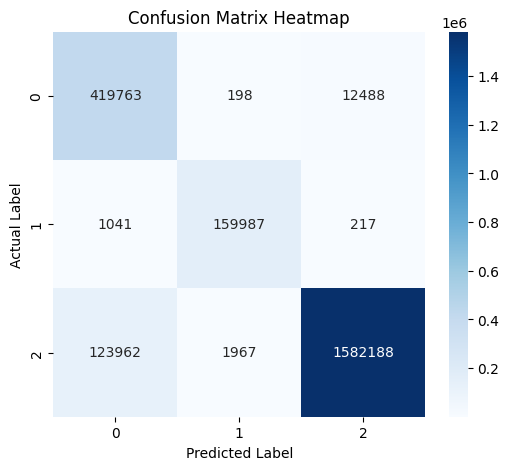

In [33]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [34]:
# Save results to csv for visual
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Save to CSV
results_df.to_csv('Nurse_Stress_Prediction_Random_Forest_results.csv', index=False)


## Model 2 - Deep Learning Long Short Term Memory (LSTM) Model


Predicting electro dermal activity (EDA) using the other variables in the dataset in a Long Short Term Memory (LSTM) deep learning model.

In [10]:
# Create a copy of the data called d3
df3 = df2.copy()

In [11]:
# Orient data by time
df3 = df3.sort_values('datetime')

In [12]:
# Ensure datetime is in pd.datetime
df3['datetime'] = pd.to_datetime(df3['datetime'])

In [13]:
# Filter the data to only include june through august data
df_subset = df3[(df3['datetime'].dt.month >= 6) & (df3['datetime'].dt.month <= 8)]

In [14]:
# Print total number of rows in df_subset
print(f"Total number of rows in df_subset: {len(df_subset)}")

Total number of rows in df_subset: 7368560


In [15]:
# Define nurse id as id
nurse_ids = df_subset['id_encoded'].unique()

# Print row count for each nurse in subset dataframe
for nurse_id in nurse_ids:
    nurse_data = df_subset[df_subset['id_encoded'] == nurse_id]
    print(f"Nurse ID {nurse_id}: {len(nurse_data)} rows")

Nurse ID 4: 689971 rows
Nurse ID 2: 825549 rows
Nurse ID 1: 773768 rows
Nurse ID 8: 447853 rows
Nurse ID 12: 1187444 rows
Nurse ID 10: 675844 rows
Nurse ID 0: 309131 rows
Nurse ID 14: 535706 rows
Nurse ID 7: 423763 rows
Nurse ID 3: 591363 rows
Nurse ID 11: 908168 rows


In [16]:
#Take the first rows from each nurse to get a representative sample but a smaller set of overal data
df_subset = df_subset.groupby('id_encoded').head(10000)

In [17]:
df_subset['time_of_day'] = df_subset['datetime'].dt.hour * 60 + df_subset['datetime'].dt.minute
df_subset['day_of_week'] = df_subset['datetime'].dt.dayofweek
df_subset['day_of_month'] = df_subset['datetime'].dt.day

In [92]:
# Store datetime seperately
datetime_col = df_subset['datetime']

# Normalize the data using minmax scaler
scaler = MinMaxScaler()
df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP','time_of_day','day_of_week','day_of_month',]] = scaler.fit_transform(df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP','time_of_day','day_of_week','day_of_month']])

In [21]:
# Get unique nurse IDs
unique_nurse_ids = df_subset['id_encoded'].unique()

# Determine the number of nurses
num_nurses = len(unique_nurse_ids)

# Keep the last nurses for validation
val_nurse_ids = unique_nurse_ids[-3:]

# Create training and validation sets based on nurse IDs
train_df = df_subset[~df_subset['id_encoded'].isin(val_nurse_ids)]
val_df = df_subset[df_subset['id_encoded'].isin(val_nurse_ids)]

In [22]:
# Print the length of the train and val df
print(f"Length of train_df: {len(train_df)}")
print(f"Length of val_df: {len(val_df)}")

Length of train_df: 80000
Length of val_df: 30000


In [23]:
# Define features using almost all features plus additional based off datetime data
features = ['X', 'Y', 'Z', 'HR', 'TEMP', 'label', 'id_encoded','time_of_day', 'day_of_week','day_of_month']
label_column =  'EDA'

#
def create_sequences(group, sequence_length, ph):
    sequences = []
    labels = []
    for i in range(len(group) - sequence_length - ph + 1):
        seq = group[features].iloc[i:i+sequence_length].values
        label = group[label_column].iloc[i + sequence_length + ph - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Use smaller sequence lengths for RAM utilization, also larger sequences didn't seem to yield meaningful results
sequence_length = 20  # 30 time steps
ph = 5  # 5 time steps

X_sequences = []
y_sequences = []

for nurse_id in tqdm(train_df['id_encoded'].unique(), desc="Processing nurses"):
    nurse_data = train_df[train_df['id_encoded'] == nurse_id]
    X_seq, y_seq = create_sequences(nurse_data, sequence_length, ph)
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

# Combine all sequences
X_sequences = np.concatenate(X_sequences)
y_sequences = np.concatenate(y_sequences)

print(f"Total sequences: {len(X_sequences)}")
print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_sequences: {y_sequences.shape}")

Processing nurses: 100%|██████████| 8/8 [00:51<00:00,  6.49s/it]

Total sequences: 79808
Shape of X_sequences: (79808, 20, 10)
Shape of y_sequences: (79808,)


In [24]:
# Adjust the X and y sequences into numpy arrays to ensure they're in the correct format for tensor flow
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [28]:
# Define input shape
input_shape = (sequence_length, len(features))

# Fit the model, using less complexity in the model to slow down training
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(32, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(16),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Define the optimizer, using slower learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss='mse', optimizer=optimizer)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 20, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 20, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,217 (137.57 KB)

 Trainable params: 34,993 (136.69 KB)

 Non-trainable params: 224 (896.00 B)

In [29]:
# Calculate the number of samples for validation
val_size = int(len(X_sequences) * 0.2)

# Split the data, keeping the last 20% for validation
X_train = X_sequences[:-val_size]
y_train = y_sequences[:-val_size]
X_val = X_sequences[-val_size:]
y_val = y_sequences[-val_size:]

# Define the number of epochs and batch size
epochs = 30
batch_size = 64

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ],
    verbose=1
)

Epoch 1/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 0.9741 - val_loss: 0.1362 - learning_rate: 1.0000e-04
Epoch 2/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.4003 - val_loss: 0.1333 - learning_rate: 1.0000e-04
Epoch 3/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.2535 - val_loss: 0.0842 - learning_rate: 1.0000e-04
Epoch 4/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.1608 - val_loss: 0.0434 - learning_rate: 1.0000e-04
Epoch 5/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0997 - val_loss: 0.0280 - learning_rate: 1.0000e-04
Epoch 6/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.0600 - val_loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 7/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0367 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 8/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0216 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 9/30
998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.0142 - v

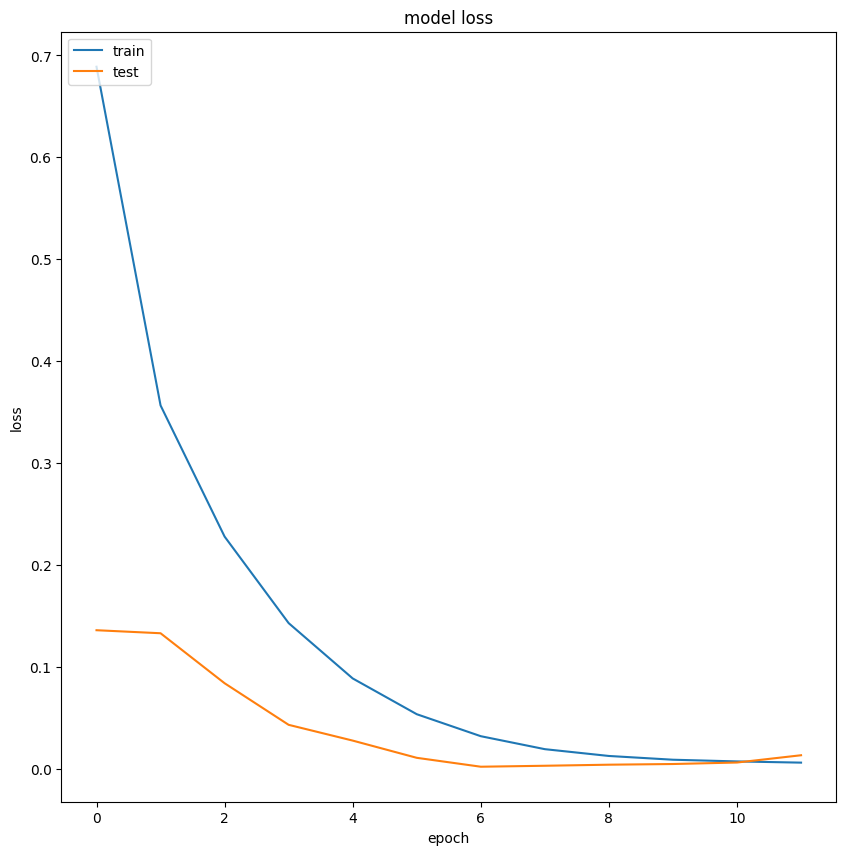

In [30]:
# Summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


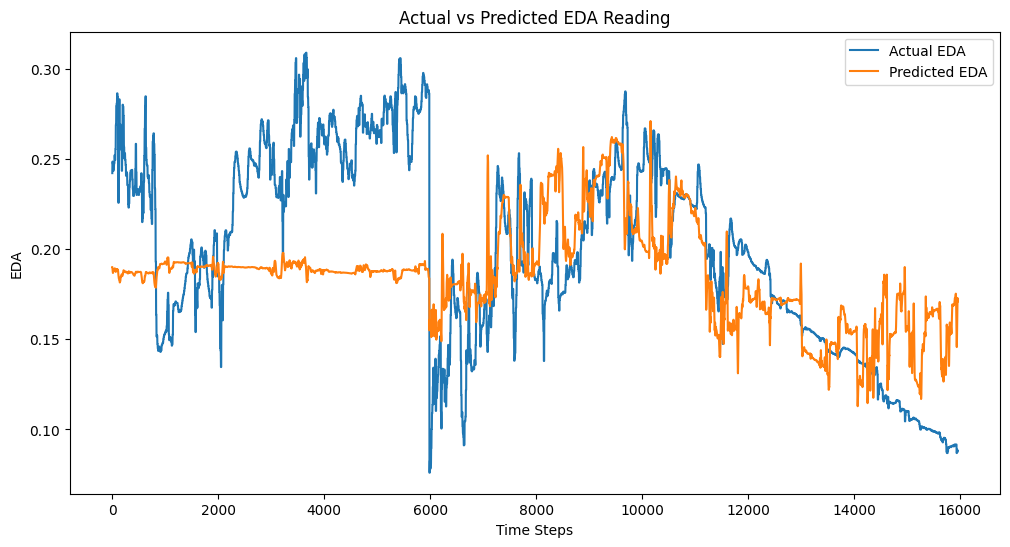

In [56]:
# Use X_val and y_val for prediction
predictions = model.predict(X_val)

# Use y_val and labels to chart actual versus predicted
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual EDA')
plt.plot(predictions, label='Predicted EDA')
plt.title('Actual vs Predicted EDA Reading')
plt.xlabel('Time Steps')
plt.ylabel('EDA')
plt.legend()
plt.show()

In [96]:
# Code thanks to amarbut and Univeristy of San Diego AAI 530
# Create arrays for sequences from validation data to predict with trained model
val_arrays = []
val_labs = []

# Create sequences
for i in range(len(val_df) - sequence_length - ph):
    if i + sequence_length + ph < len(val_df):
        val_arrays.append(val_df[features].iloc[i:i+sequence_length].values)
        val_labs.append(val_df['EDA'].iloc[i+sequence_length+ph-1])


# Convert datatype to np.float32
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)

# Convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


In [97]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test))
print("")

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)

# Make predictions on the validation sequences above, the data that was not used in training
predictions = model.predict(val_arrays)

936/936 - 2s - 3ms/step - loss: 0.1055

MSE: 0.10547330230474472

936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
936/936 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


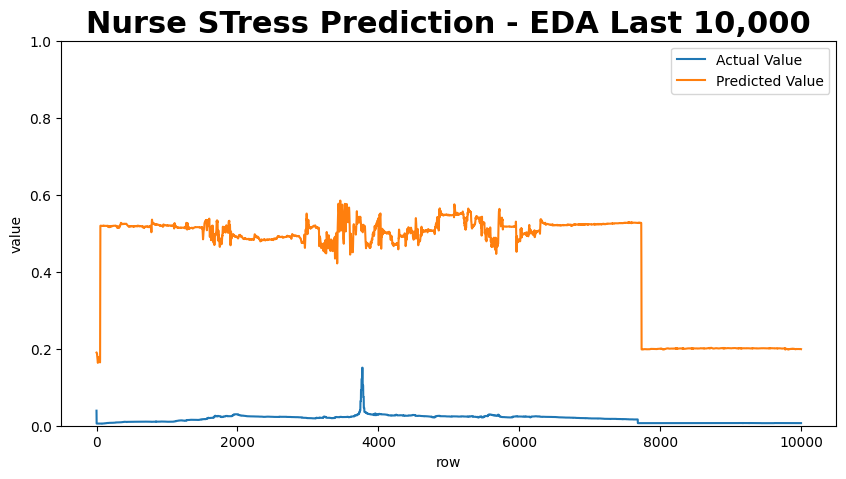

In [98]:
# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_true_test[-10000:], label = 'Actual Value')
plt.plot(y_pred_test[-10000:], label = 'Predicted Value')
plt.title('Nurse STress Prediction - EDA Last 10,000', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.ylim(0, 1) # Set y-axis limits from 0 to 1 for normalized data
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [99]:
# Flatten results into variables
y_true_test = val_labs.flatten()
y_pred_test = predictions.flatten()

# Add y true and y pred variables to dataset
resutls_df = pd.DataFrame({
    'y_true': y_true_test,
    'y_pred': y_pred_test
})

# Convert to csv
resutls_df.to_csv('Nurse_Stress_Prediction_LSTM_results.csv', index=False)